/tmp/ipython-input-447599367.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2022-01-01', end='2025-09-01')
[*********************100%***********************]  1 of 1 completed


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Cross-Validation Accuracy: 0.5153
Classification Test Accuracy: 0.48554913294797686
              precision    recall  f1-score   support

           0       0.48      0.32      0.39        87
           1       0.49      0.65      0.56        86

    accuracy                           0.49       173
   macro avg       0.48      0.49      0.47       173
weighted avg       0.48      0.49      0.47       173



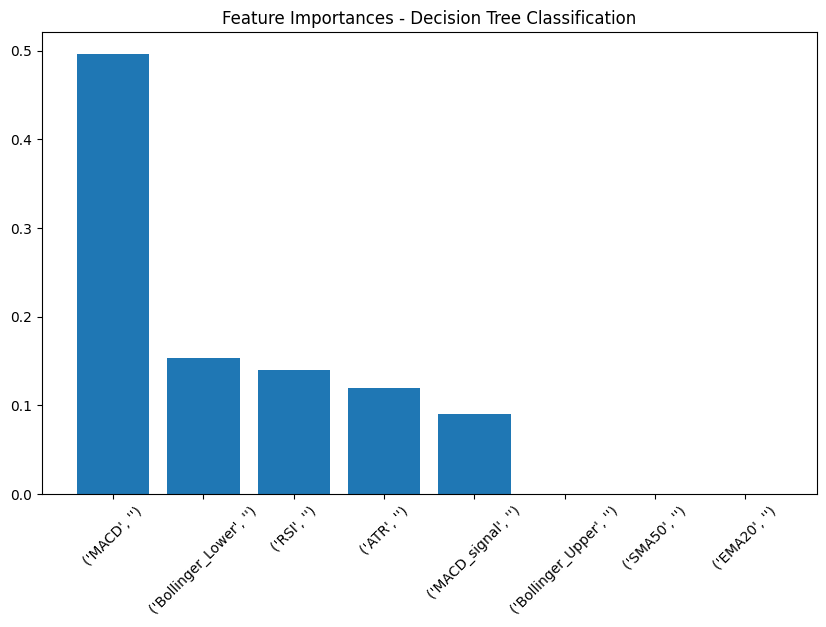


--- Price Prediction ---
Predicted prices for the next 3 days: [np.float64(753.2683423262006), np.float64(755.2834330720505), np.float64(757.1647672358258)]


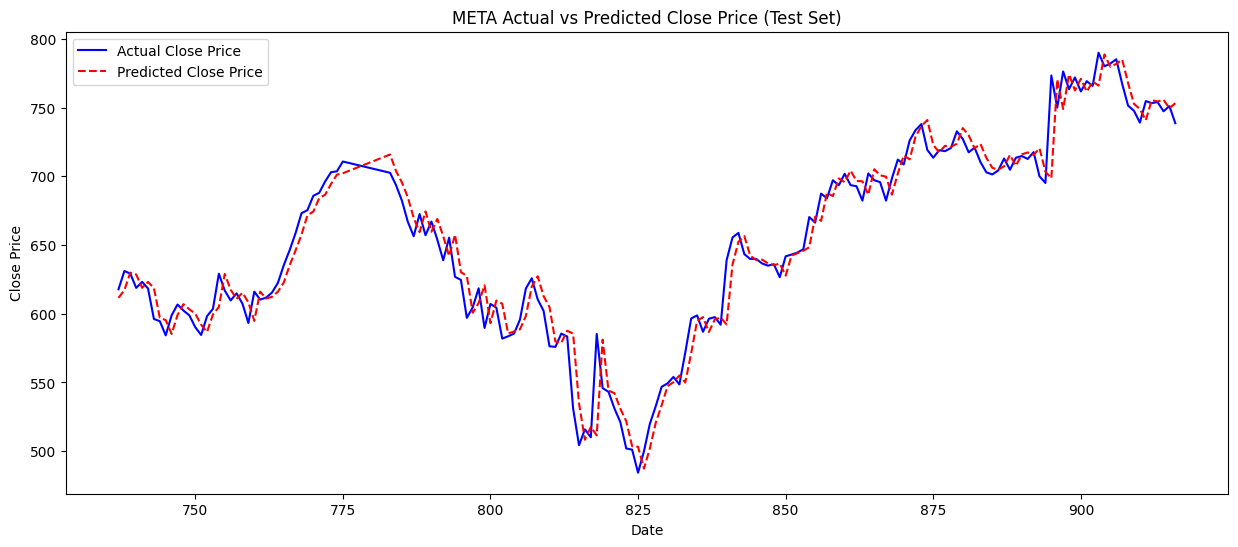

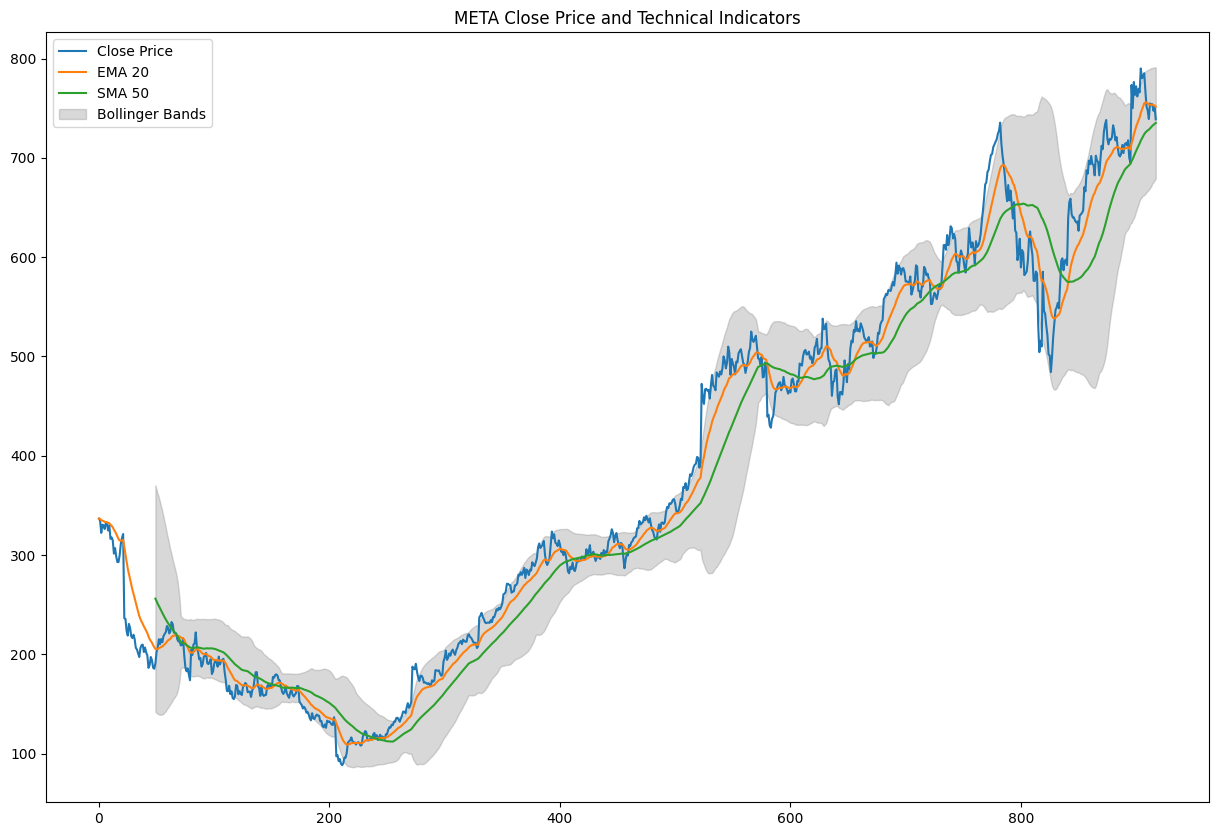

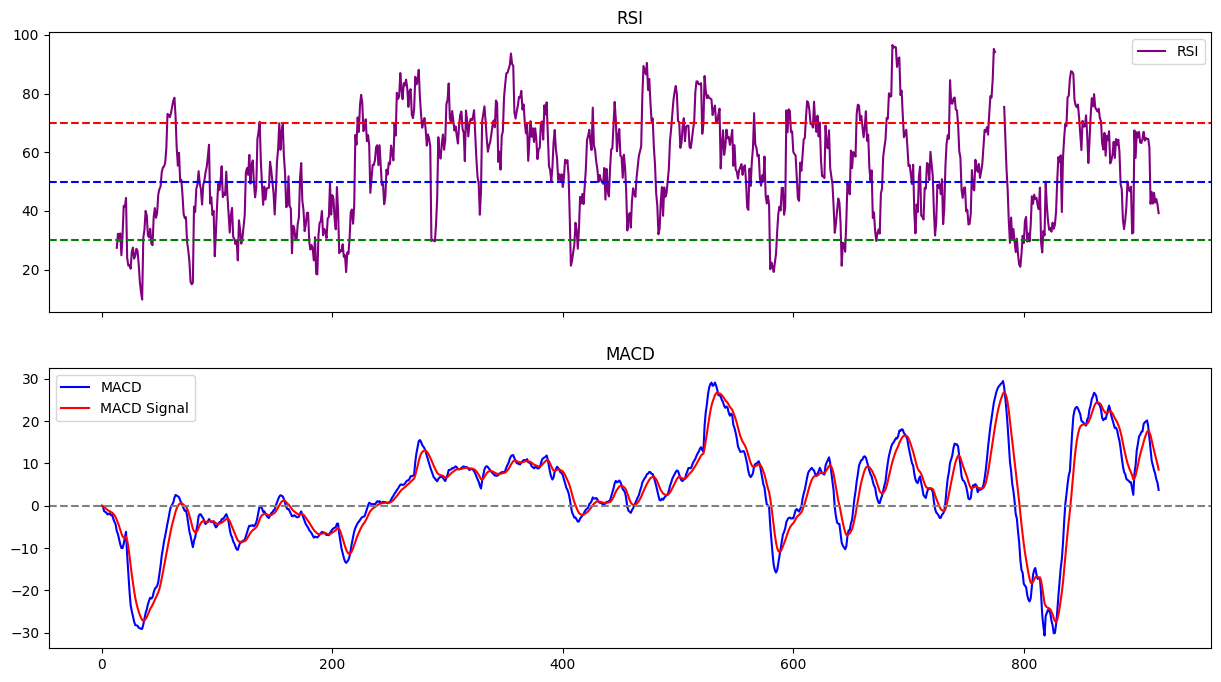

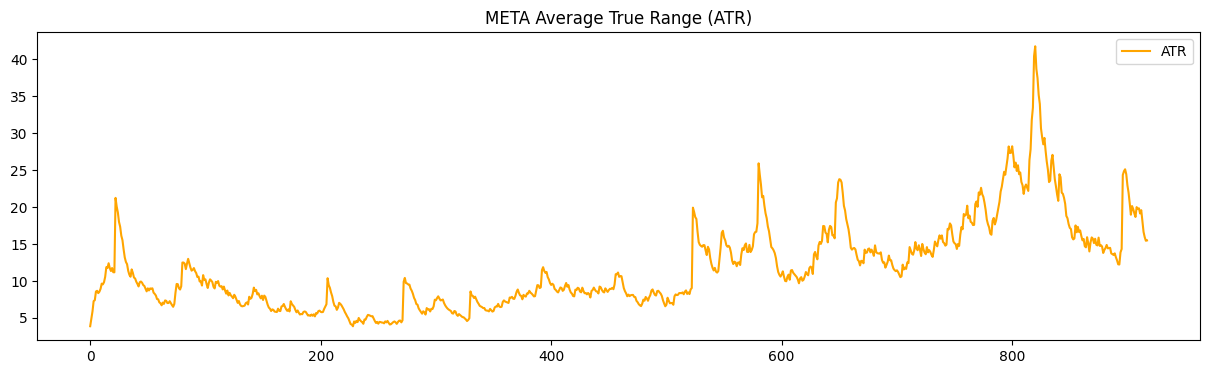

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LinearRegression # Import Linear Regression

# Fetch Meta stock data
ticker = 'META'
df = yf.download(ticker, start='2022-01-01', end='2025-09-01')

# Reset the index to flatten it
df = df.reset_index()

# Calculate indicators
close = df['Close']
high = df['High']
low = df['Low']

# EMA (20)
df['EMA20'] = close.ewm(span=20, adjust=False).mean()

# SMA (50)
df['SMA50'] = close.rolling(window=50).mean()

# Bollinger Bands (SMA50 ± 2 std dev)
rolling_std = close.rolling(window=50).std()
df['Bollinger_Upper'] = df['SMA50'] + 2 * rolling_std.iloc[:, 0]
df['Bollinger_Lower'] = df['SMA50'] - 2 * rolling_std.iloc[:, 0]

# RSI (14)
delta = close.diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss.replace(0, np.nan)
df['RSI'] = 100 - (100 / (1 + rs))

# MACD (12-26 EMAs)
ema_12 = close.ewm(span=12, adjust=False).mean()
ema_26 = close.ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Average True Range (ATR) (14)
high_low = high - low
high_close = (high - close.shift()).abs()
low_close = (low - close.shift()).abs()
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR'] = tr.ewm(span=14, adjust=False).mean()


# Prepare features for ML classification model
# Use today's features to predict if next day's close price will go up (1) or not (0)
df['Target_Classification'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop rows with NaN values created by indicators for classification model
df_classification = df.dropna().copy() # Create a copy to avoid SettingWithCopyWarning

# Use only indicators as features for classification
features_classification = ['EMA20', 'SMA50', 'RSI', 'MACD', 'MACD_signal',
                           'Bollinger_Upper', 'Bollinger_Lower', 'ATR']

X_classification = df_classification[features_classification]
y_classification = df_classification['Target_Classification']

# Train-test split for classification
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(X_classification, y_classification, shuffle=False, test_size=0.2)

# Enhanced hyperparameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(3, 21)),
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train_classification, y_train_classification)

best_model_classification = grid_search.best_estimator_
print(f"Best Decision Tree Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Prediction & evaluation for classification
y_pred_classification = best_model_classification.predict(X_test_classification)
print("Classification Test Accuracy:", accuracy_score(y_test_classification, y_pred_classification))
print(classification_report(y_test_classification, y_pred_classification))

# Plot Feature Importance
importances = best_model_classification.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_classification.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importances - Decision Tree Classification")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.show()

# --- Price Prediction Model ---

# Prepare data for regression model
# Use today's features to predict the next day's close price
df['Target_Regression'] = df['Close'].shift(-1)

# Drop rows with NaN values for regression model
df_regression = df.dropna().copy() # Create a copy

# Use all indicators and Close price as features for regression
features_regression = ['Close', 'EMA20', 'SMA50', 'RSI', 'MACD', 'MACD_signal',
                       'Bollinger_Upper', 'Bollinger_Lower', 'ATR']

X_regression = df_regression[features_regression]
y_regression = df_regression['Target_Regression']

# Train-test split for regression
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression, y_regression, shuffle=False, test_size=0.2)

# Train a Linear Regression model
model_regression = LinearRegression()
model_regression.fit(X_train_regression, y_train_regression)

# Make predictions on the test set
y_pred_regression = model_regression.predict(X_test_regression)

# Predict the next 3 days' prices
last_day_features = df_regression[features_regression].iloc[-1].values.reshape(1, -1)
future_predictions = []

for _ in range(3):
    next_day_prediction = model_regression.predict(last_day_features)[0]
    future_predictions.append(next_day_prediction)
    # For the next prediction, use the predicted price as the 'Close' feature
    last_day_features[0][features_regression.index('Close')] = next_day_prediction
    # You might want to update other features based on how they relate to the new close price
    # For simplicity here, we only update the 'Close' feature in the features used for prediction


print("\n--- Price Prediction ---")
print("Predicted prices for the next 3 days:", future_predictions)

# Plotting actual vs predicted prices for the test set
plt.figure(figsize=(15, 6))
plt.plot(y_test_regression.index, y_test_regression, label='Actual Close Price', color='blue')
plt.plot(X_test_regression.index, y_pred_regression, label='Predicted Close Price', color='red', linestyle='--')
plt.title(f"{ticker} Actual vs Predicted Close Price (Test Set)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plotting stock close price with indicators
plt.figure(figsize=(15,10))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['EMA20'], label='EMA 20')
plt.plot(df['SMA50'], label='SMA 50')
plt.fill_between(df.index, df['Bollinger_Upper'], df['Bollinger_Lower'], color='grey', alpha=0.3, label='Bollinger Bands')
plt.title(f"{ticker} Close Price and Technical Indicators")
plt.legend()
plt.show()

# Plot RSI and MACD
fig, axs = plt.subplots(2, 1, figsize=(15,8), sharex=True)

axs[0].plot(df['RSI'], label='RSI', color='purple')
axs[0].axhline(70, color='red', linestyle='--')
axs[0].axhline(30, color='green', linestyle='--')
axs[0].axhline(50, color='blue', linestyle='--') # Added 50 level for RSI
axs[0].set_title('RSI')
axs[0].legend()

axs[1].plot(df['MACD'], label='MACD', color='blue')
axs[1].plot(df['MACD_signal'], label='MACD Signal', color='red')
axs[1].axhline(0, color='grey', linestyle='--') # Added zero line for MACD
axs[1].set_title('MACD')
axs[1].legend()

plt.show()

# Plot ATR separately
plt.figure(figsize=(15, 4))
plt.plot(df['ATR'], label='ATR', color='orange')
plt.title(f"{ticker} Average True Range (ATR)")
plt.legend()
plt.show()

# Task
Push the current notebook to an existing GitHub repository.

## Install git

### Subtask:
If you don't have Git installed, install it on your system.


## Initialize a local git repository

### Subtask:
In the directory where your notebook is saved, initialize a local Git repository.


## Add your code to the local repository

### Subtask:
Stage and commit your notebook file to the local Git repository.


## Connect your local repository to the github repository

### Subtask:
Add the remote origin URL of your existing GitHub repository to your local Git repository.


## Push your code to the github repository

### Subtask:
Push your committed changes from your local Git repository to the remote repository on GitHub.


## Summary:

### Data Analysis Key Findings

*   The entire process of pushing a notebook to an existing GitHub repository failed at every step.
*   The core reason for the failures across all steps is the AI's inability to execute local shell commands or interact with the user's local file system and terminal. This limitation prevents the AI from performing essential Git operations like installing Git, initializing a repository, adding and committing files, adding a remote origin, and pushing changes.

### Insights or Next Steps

*   The user needs to manually perform all the Git commands outlined in the steps using their local terminal to successfully push the notebook to their GitHub repository.
